# Compare 2 Surf En

In [3]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from calculations import observables as calc
from calculations import triangular as tri
from manage import utils

sns.set_theme()

###

data_dirs = [
    "/home/max/projects/apfc/data/05n0",
    "/home/max/projects/apfc/data/05n0"
]

surf_en_indeces = [0, -1]

names = ["first index", "last index"]

colors = ["r", "b"]
line_widths = [1, 1]

normalize = False

add_lim = 0.01

first index eps: -0.0035, gamma0: -0.0020
last index eps: -0.0017, gamma0: -0.0100


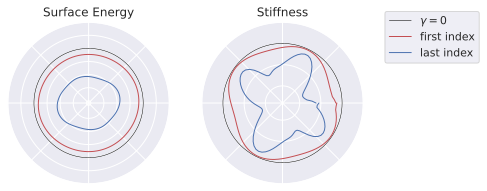

In [4]:
def norm(arr):
    ret = arr - np.min(arr)
    return ret / np.max(ret) 

def fill(arr, div, add=False):

    max_ = np.max(arr)

    o_arr = arr.copy()[1:]
    do_add_int = int(add)

    for i in range(1, div):
        add_arr = do_add_int * i * max_
        arr = np.hstack([arr, o_arr + add_arr])

    return arr

configs = []
thetas = []
thetas_str = []
surf_ens = []
stiffs = []
fits = []

for data_dir in data_dirs:

    ### Config ###

    config_path = f"{data_dir}/config.json"
    with open(config_path, "r") as f:
        config = json.load(f)

    ### Surf En ###

    surf_en = pd.read_csv(f"{data_dir}/evaluate/surf_en.csv", index_col=0)
    surf_en = surf_en.apply(pd.to_numeric)

    ### Thetas ###

    theta_str = surf_en.columns.to_numpy()
    theta = utils.get_thetas(config)

    ### stiffness ###

    stiff = pd.read_csv(f"{data_dir}/evaluate/stiff.csv", index_col=0)
    stiff = stiff.apply(pd.to_numeric)

    ## fits ###

    fit = pd.read_csv(f"{data_dir}/evaluate/fits.csv", index_col=0)
    fit = fit.apply(pd.to_numeric)

    ### Fill ###

    div = config["thetaDiv"]
    theta = utils.fill(theta, div, True)

    ### Appends ###normalize
    
    configs.append(config)
    surf_ens.append(surf_en)
    thetas.append(theta)
    thetas_str.append(theta_str)
    stiffs.append(stiff)
    fits.append(fit)

###

fig = plt.figure()
ax_surf = plt.subplot(121, projection="polar")
ax_stiff = plt.subplot(122, projection="polar")

ax_surf.set_aspect("equal")
ax_stiff.set_aspect("equal")

plot_stiff = []
plot_surf = []
surf_lim = [0., 0.]
stiff_lim = [0., 0.]

for i in range(len(surf_ens)):

    surf = surf_ens[i].iloc[surf_en_indeces[i], :].to_numpy()
    stiff = stiffs[i].iloc[surf_en_indeces[i], :].to_numpy()

    if normalize:

        surf = norm(surf)
        stiff = norm(stiff)

    plot_stiff.append(stiff)
    plot_surf.append(surf)

    surf_lim[0] = np.min([surf_lim[0], np.min(surf)])
    stiff_lim[0] = np.min([stiff_lim[0], np.min(stiff)])

    surf_lim[1] = np.max([surf_lim[1], np.max(surf)])
    stiff_lim[1] = np.max([stiff_lim[1], np.max(stiff)])

surf_lim[1] += add_lim
stiff_lim[1] += add_lim

surf_lim[0] -= add_lim
stiff_lim[0] -= add_lim

if surf_lim[0] < 0 < surf_lim[1]:
    ax_surf.plot(thetas[0], np.zeros(thetas[0].shape), c="black", lw=0.5)

if stiff_lim[0] < 0 < stiff_lim[1]:
    ax_stiff.plot(thetas[0], np.zeros(thetas[0].shape), c="black", label="$\\gamma=0$", lw=0.5)

for i in range(len(plot_surf)):

    ax_surf.plot(thetas[i], plot_surf[i], c=colors[i], label=names[i], lw=line_widths[i])
    ax_stiff.plot(thetas[i], plot_stiff[i], c=colors[i], label=names[i], lw=line_widths[i])

    try:
        eps, gamma0 = tri.fit_surf_en(thetas[i], plot_surf[i])
        print(names[i], f"eps: {eps:.4f}, gamma0: {gamma0:.4f}")
    except ValueError as e:
        pass

ax_surf.set_title("Surface Energy")
ax_stiff.set_title("Stiffness")
ax_stiff.legend(bbox_to_anchor=(1.1, 1.1))

ax_surf.set_xticklabels([])
ax_surf.set_yticklabels([])
ax_stiff.set_xticklabels([])
ax_stiff.set_yticklabels([])

ax_surf.set_ylim(surf_lim)
ax_stiff.set_ylim(stiff_lim)

plt.show()

# Plot Volume 1D

In [3]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from calculations import observables
from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/05n0"
plot_i = -1
add_max = 5
use_real_min = False
ignore_eta_index = {}

do_polar_plot = True
calc_min_max = True

In [4]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

x = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
dx = np.abs(x[0] - x[1])

#################

volume_dics = [{t: [] for t in thetas_str} for _ in range(eta_count)]

for theta_i, theta in enumerate(thetas):

    theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
    eta_it = rw.EtaIterator(
        theta_dir,
        config["numPtsX"],
        config["numPtsY"],
        eta_count,
        float,
        False
    )

    for etas in eta_it:
        for eta_i in range(eta_count):
            sol_ar, liq_ar = observables.get_phase_volumes(etas[eta_i], dx)
            volume_dics[eta_i][thetas_str[theta_i]].append(sol_ar)

thetas = utils.fill(thetas, config["thetaDiv"], True)
thetas_str = [f"{theta:.4f}" for theta in thetas]

volume_dfs = []
for eta_i in range(eta_count):
    df = pd.DataFrame(volume_dics[eta_i])
    df = utils.fill_df(df, thetas_str, config["thetaDiv"])
    volume_dfs.append(df)

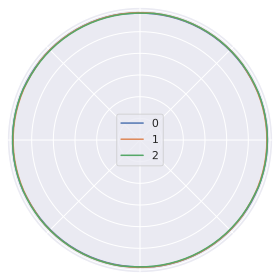

In [5]:
fig = plt.figure()

if do_polar_plot:
    ax = plt.subplot(111, projection="polar")
    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
else:
    ax = plt.subplot(111)

max_val = 0.
min_val = 1e10

for eta_i in range(eta_count):

    if eta_i in ignore_eta_index:
        continue

    volume_row = volume_dfs[eta_i].iloc[plot_i].to_numpy()

    max_val = np.max([max_val, np.max(volume_row)])
    min_val = np.min([min_val, np.min(volume_row)])

    ax.plot(thetas, volume_row, label=f"{eta_i}")

if calc_min_max:
    ax.set_ylim([min_val if use_real_min else 0, max_val + add_max])

ax.legend()
plt.show()

# Reconstruct 2D from 1D theta sims

In [6]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/05n0"
plot_i = -1

pt_size = 1

In [7]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

x_full = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
x, _ = utils.get_positive_range(x_full, np.zeros(x_full.shape))
y = np.zeros(x.shape)
xy = np.array([x, y])

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        # this condition is to avoid double printing of the bounds
        if theta_i == thetas.shape[0] - 1:
            continue

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        _, eta_sum = utils.get_positive_range(x_full, eta_sum)

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size)

plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Reconstruct 2D from 1D with Tangents

In [ ]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw
from calculations import observables

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/05n0"
plot_i = -1

pt_size = 0.01

line_plot_color="g"
line_plot_width = 2
line_add_rot = np.pi/6

alpha = 1

line_angles = np.array([
    i * np.pi/3 for i in range(6)
])

r=58.13813813813624
r=58.13813813813624
r=58.13813813813624
r=58.13813813813624
r=58.13813813813624
r=58.13813813813624


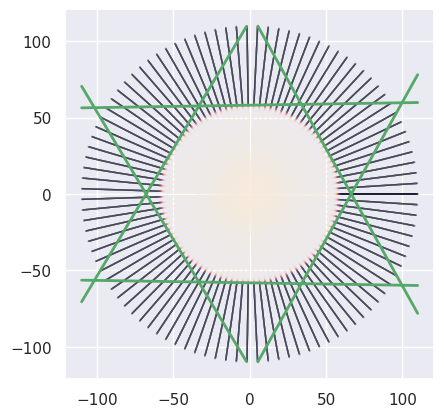

In [ ]:
line_angles += line_add_rot

sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

thetas_angle_is = []
for line_angle in line_angles:
    theta_diff = np.abs(thetas - line_angle)
    theta_i = np.argmin(theta_diff)
    thetas_angle_is.append(theta_i)

x_line = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
is_get_0_i = (x_line >= 0).nonzero()
x = x_line[is_get_0_i]
y = np.zeros(x.shape)
xy = np.array([x, y])
dx = np.abs(x[0]-x[1])

# fmt: off
rot_90_deg = np.array([
    [np.cos(np.pi/2), -np.sin(np.pi/2)],
    [np.sin(np.pi/2), np.cos(np.pi/2)]
])
# fmt: on

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        eta_sum = eta_sum[is_get_0_i]

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size, alpha=alpha)

        if theta_i in thetas_angle_is:
            
            r, _ = observables.get_phase_volumes(eta_sum, dx)
            print(f"r={r}")
            xy_base = np.array([r*np.cos(theta), r*np.sin(theta)])
            xy_line = rot_90_deg.dot(xy_base)

            m = xy_line[1] / xy_line[0]
            n = xy_base[1] - m * xy_base[0]

            y_line = m * x_line + n
            line_bounds = np.logical_and(
                y_line < config["xlim"],
                y_line > -config["xlim"]
            )

            y_line_plot = y_line[line_bounds]
            x_line_plot = x_line[line_bounds]

            if m > 1e5:

                ax.vlines(
                    xy_base[0], 
                    -config["xlim"], 
                    config["xlim"],
                    color=line_plot_color,
                    lw=line_plot_width
                )

            else:

                ax.plot(
                    x_line_plot, 
                    y_line_plot, 
                    c=line_plot_color, 
                    lw=line_plot_width
                )
            

plt.show()

In [ ]:
from calculations import params

config_path = "/home/max/projects/apfc/data/2d01n0"

config = utils.get_config(config_path)

t = config["t"]
v = config["v"]

n0 = config["n0"]

C = params.C(config, n0)
B = params.B(config, n0)
sign = sign = -1 if n0 > t else 1

def a(n0, db0, sign):

    ret = 1 + 16 * n0 + 20 * (db0 - 16 * n0**2)
    ret = 2 - 4 * n0 + sign * 2 * np.sqrt(ret)

    return ret / 24

print((-C + sign * np.sqrt(C**2 - 15 * v * B)) / (15 * v))
print(C, B)
print(C**2 - 15 * v * B)
print(a(n0, config["dB0"], sign))

-0.11953771205031453
0.349 0.011990999999999974
0.06184600000000011
nan


/tmp/ipykernel_8703/1296342095.py:19: RuntimeWarning: invalid value encountered in sqrt
  ret = 2 - 4 * n0 + sign * 2 * np.sqrt(ret)


In [ ]:
config_path = "/home/max/projects/apfc/data/05n0"
config = utils.get_config(config_path)

line_angle = np.pi/6

thetas = utils.get_thetas(config)
theta_diff = np.abs(thetas - line_angle)
theta_i = np.argmin(theta_diff)

print(thetas[theta_i])




0.5077321460347141


In [1]:
from manage import utils
from calculations import params, observables
import scipy

def phi(etas):

    ret = np.zeros(etas[0].shape, dtype=float)
    for eta_i in range(etas.shape[0]):
        ret += etas[eta_i] * np.conj(etas[eta_i])
    return 2 * ret


def sub_energy_functional_1d(etas, n0, x, config, G):

    a = params.A(config)
    b = params.B(config, n0)
    d = params.D(config)
    e = params.E(config, n0)

    phi_ = phi(etas)
    tri_f = triangular_one_mode_func(etas, n0, config)

    sum_ = np.zeros(etas[0].shape)
    for eta_i in range(etas.shape[0]):

        deta = np.gradient(etas[eta_i].flatten(), x)
        d2eta = np.gradient(deta, x)

        G_elem = get_g_elem(G, theta)

        op = d2eta + 2 * complex(0, 1) * G_elem * deta
        op = np.real(op * np.conj(op))

        sum_ += a * op - 3 * d / 2 * etas[eta_i] ** 4

    ret = b / 2 * phi_
    ret += 3 * d / 4 * phi_**2
    ret += op + tri_f + e

    return ret


def get_chemical_potential(etas, n0, config):

    phi_ = phi(etas)

    p = np.ones(etas[0].shape)
    for eta_i in range(etas.shape[0]):
        p *= etas[eta_i]
    p += np.conj(p)
    p *= 2

    ret = (config["dB0"] + config["Bx"]) * n0
    ret += 3 * config["v"] * phi_ * n0
    ret += 3 * config["v"] * p
    ret -= phi_ * config["t"]
    ret -= config["t"] * n0**2
    ret += config["v"] * n0**3

    return ret


def triangular_one_mode_func(etas, n0, config):

    c = params.C(config, n0)

    ret = np.ones(etas[0].shape)
    for eta_i in range(etas.shape[0]):
        ret *= etas[eta_i]

    ret += np.conj(ret)

    return 2 * c * ret

def s(etas, n0, config, theta, rotate_G=True, div_interface_width=False):

    config = config.copy()
    eta_count = etas.shape[0]

    is_n0_sim = config["simType"] == "n0"

    ##########################
    ### get positive range ###
    ##########################

    x_full = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
    x, etas = utils.get_positive_range(x_full, etas, True)
    if is_n0_sim:
        _, n0 = utils.get_positive_range(x_full, n0)

    ################
    ### rotate G ###
    ################

    G = np.array(config["G"])
    G_rot = G.copy()

    if rotate_G:

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        for eta_i in range(eta_count):
            G_rot[eta_i] = rot.dot(G[eta_i])

    ###############
    ### eta sum ###
    ###############

    eta_sum = np.zeros(etas[0].shape)
    for eta_i in range(eta_count):
        eta_sum += etas[eta_i] * np.conj(etas[eta_i])

    interface_width = 1
    if div_interface_width:
        interface_width = observables.get_interface_width(x, eta_sum)

    ############################
    ### solid liquid domains ###
    ############################

    eta_sum_min = np.min(eta_sum)
    eta_sum_max = np.max(eta_sum)
    eta_sum_threshhold = (eta_sum_max - eta_sum_min) / 2

    sol_is = (eta_sum > eta_sum_threshhold).nonzero()[0]
    liq_is = (eta_sum < eta_sum_threshhold).nonzero()[0]

    etas_sol = etas[:,sol_is]
    etas_liq = etas[:,liq_is]

    n0_sol = n0[sol_is] if is_n0_sim else n0
    n0_liq = n0[liq_is] if is_n0_sim else n0

    x_sol = x[sol_is]
    x_liq = x[liq_is]
    
    ########################
    ### integrand values ###
    ########################

    f = sub_energy_functional_1d(etas, n0, x, config, G_rot)
    mu = get_chemical_potential(etas, n0, config)

    f_liq = sub_energy_functional_1d(etas_liq, n0_liq, x_liq, config, G_rot)
    mu_liq = get_chemical_potential(etas_liq, n0_liq, config)

    integ = f - mu * n0
    integ_liq = f_liq - mu_liq * n0_liq

    #################
    ### integrate ###
    #################

    omega = scipy.integrate.simpson(integ, x)
    omega_liq = scipy.integrate.simpson(integ_liq, x_liq)

    ret = omega - omega_liq
    if div_interface_width:
        ret = ret / interface_width

    return ret

In [2]:
import os
import numpy as np
import pandas as pd
from manage import read_write as rw
from manage import utils

sim_path = "/home/max/projects/apfc/data/05n0"

config = utils.get_config(sim_path)

sim_path = utils.make_path_arg_absolute(sim_path)
out_dir = f"{sim_path}/evaluate"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

eta_count = len(config["G"])
include_n0 = config["simType"] == "n0"
is_1d = config["numPtsY"] <= 1
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]
df_surf_en = pd.DataFrame(columns=thetas_str, index=range(line_count))

def get_g_elem(G, theta):

    return 1

for theta_i, theta in enumerate(thetas):

    theta_dir = f"{sim_path}/eta_files/{theta:.4f}"

    eta_it = rw.EtaIterator(
        theta_dir,
        config["numPtsX"],
        config["numPtsY"],
        eta_count,
        float,
        config["simType"] == "n0",
    )

    for entry_i, entry in enumerate(eta_it):

        if include_n0:
            etas_, n0 = entry
        else:
            etas_ = entry
            n0 = config["n0"]

        etas = np.zeros((eta_count, config["numPtsX"]))
        for eta_i in range(eta_count):
            etas[eta_i] = etas_[eta_i].flatten()

        ####################
        ## Surface Energy ##
        ####################

        surf_en = s(etas, n0, config, theta, rotate_G=True, div_interface_width=True)
        df_surf_en.iloc[entry_i, theta_i] = surf_en


df_stiff = pd.DataFrame(columns=thetas_str, index=range(line_count))
for i in range(df_surf_en.shape[0]):
    df_stiff.iloc[i, :] = observables.calc_stiffness(df_surf_en.iloc[i, :], thetas)


df_surf_en.to_csv(f"{out_dir}/surf_en.csv")
df_stiff.to_csv(f"{out_dir}/stiff.csv")
